In [1]:
import torch
torch.set_default_dtype(torch.float64)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, accuracy_score, roc_auc_score, roc_curve, confusion_matrix

BKG = 0
SIGNAL = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

2023-08-08 21:19:42.592519: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 21:19:42.622919: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 21:19:43.136294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device(type='cuda')

In [2]:
bkg_df: pd.DataFrame = pd.read_hdf("data/bkg_pythia_sanitised_features.h5")
fcnc_df: pd.DataFrame = pd.read_hdf("data/fcnc_pythia_sanitised_features.h5")
data: pd.DataFrame = pd.concat([bkg_df, fcnc_df])

## Analysing the data

In [3]:
data.columns

Index(['Electron_Multi', 'FatJet1_Eta', 'FatJet1_Mass', 'FatJet1_PT',
       'FatJet1_Phi', 'FatJet1_Tau1', 'FatJet1_Tau2', 'FatJet1_Tau3',
       'FatJet1_Tau4', 'FatJet1_Tau5', 'FatJet_Multi', 'Jet1_BTag', 'Jet1_Eta',
       'Jet1_Mass', 'Jet1_PT', 'Jet1_Phi', 'Jet2_BTag', 'Jet2_Eta',
       'Jet2_Mass', 'Jet2_PT', 'Jet2_Phi', 'Jet3_BTag', 'Jet3_Eta',
       'Jet3_Mass', 'Jet3_PT', 'Jet3_Phi', 'Jet4_BTag', 'Jet4_Eta',
       'Jet4_Mass', 'Jet4_PT', 'Jet4_Phi', 'Jet5_BTag', 'Jet5_Eta',
       'Jet5_Mass', 'Jet5_PT', 'Jet5_Phi', 'Jet_Multi', 'Lepton1_Eta',
       'Lepton1_PT', 'Lepton1_Phi', 'Lepton2_Eta', 'Lepton2_PT', 'Lepton2_Phi',
       'MissingET_MET', 'MissingET_Phi', 'Muon_Multi', 'ScalarHT_HT',
       'gen_decay1', 'gen_decay2', 'gen_decay_filter', 'gen_filter',
       'gen_label', 'gen_n_btags', 'gen_sample', 'gen_sample_filter',
       'gen_split', 'gen_weights', 'gen_xsec', 'Jet10_BTag', 'Jet10_Eta',
       'Jet10_Mass', 'Jet10_PT', 'Jet10_Phi', 'Jet6_BTag', 'Jet6_Eta',
   

In [4]:
data.shape

(1093038, 83)

There are more ```Beyond Standard Model, BSM```, events (background) than ```Standard Model, SM```, events (signal)

In [5]:
# BSM events
fcnc_df['gen_sample_filter'].unique()

array(['tZFCNC_PyDelphes'], dtype=object)

In [6]:
# SM events
bkg_df['gen_sample_filter'].unique()

array(['Zjj_HT250to500', 'ttbar_PTtop100to250', 'Zbb_HT500', 'Zjj_HT500',
       'WW_PTW250to500', 'WZ_PTZ250to500', 'ZZ_PTZ0to250', 'WW_PTW500',
       'Zbb_HT250to500', 'WZ_PTZ0to250', 'ZZ_PTZ250to500', 'Zjj_HT0to250',
       'ttbar_PTtop250', 'ZZ_PTZ500', 'WZ_PTZ500', 'Zbb_HT0to250',
       'ttbar_PTtop0to100', 'WW_PTW0to250'], dtype=object)

```gen_label``` column tells us if an event is background or signal.


```gen_xsec``` column tells us the weight associated with each event.

In [7]:
data.rename(columns={
    'gen_label': 'is_signal',
    'gen_xsec': 'weight',
}, inplace=True)

```is_signal``` is either "bkg" or "signal" so let's map to 0, 1.

In [8]:
data['is_signal'] = data['is_signal'].map({'bkg': BKG, 'signal': SIGNAL})

All other columns starting with ```gen``` were created in the Monte Carlo simulation so they can be dropped. Nan values are also dropped.

In [9]:
data = data[[col for col in data.columns if 'gen' not in col]]
data.dropna(axis=1, inplace=True)

The remaining columns represent events that can be ```detected```, if it's ```SM``` or ```BSM```, and the ```weight``` associated with each event.

In [10]:
data.columns

Index(['Electron_Multi', 'FatJet1_Eta', 'FatJet1_Mass', 'FatJet1_PT',
       'FatJet1_Phi', 'FatJet1_Tau1', 'FatJet1_Tau2', 'FatJet1_Tau3',
       'FatJet1_Tau4', 'FatJet1_Tau5', 'FatJet_Multi', 'Jet1_BTag', 'Jet1_Eta',
       'Jet1_Mass', 'Jet1_PT', 'Jet1_Phi', 'Jet2_BTag', 'Jet2_Eta',
       'Jet2_Mass', 'Jet2_PT', 'Jet2_Phi', 'Jet3_BTag', 'Jet3_Eta',
       'Jet3_Mass', 'Jet3_PT', 'Jet3_Phi', 'Jet4_BTag', 'Jet4_Eta',
       'Jet4_Mass', 'Jet4_PT', 'Jet4_Phi', 'Jet5_BTag', 'Jet5_Eta',
       'Jet5_Mass', 'Jet5_PT', 'Jet5_Phi', 'Jet_Multi', 'Lepton1_Eta',
       'Lepton1_PT', 'Lepton1_Phi', 'Lepton2_Eta', 'Lepton2_PT', 'Lepton2_Phi',
       'MissingET_MET', 'MissingET_Phi', 'Muon_Multi', 'ScalarHT_HT',
       'is_signal', 'weight'],
      dtype='object')

There is alot more background than signal.

In [11]:
bkg_len, fcnc_len = bkg_df.shape[0], fcnc_df.shape[0]
total = bkg_len + fcnc_len
print(total == len(data))
# Get relative percentage
bkg_percentage = bkg_len / total
fcnc_percentage = fcnc_len / total

bkg_percentage, fcnc_percentage

True


(0.9171593302337155, 0.08284066976628443)

In [12]:
data.shape

(1093038, 49)

```Why is normalization done only on sampled data?```

In [13]:
# Sample the hole dataset
sample = 100000
fcnc_sample = int(sample * fcnc_percentage)
bkg_sample = int(sample * bkg_percentage)

bkg = data[data['is_signal'] == BKG].sample(bkg_sample, random_state=42)
fcnc = data[data['is_signal'] == SIGNAL].sample(fcnc_sample, random_state=42)

bkg.shape, fcnc.shape

((91715, 49), (8284, 49))

In [14]:
# Splot into train, test and validation dataframes
fcnc_train_df, fcnc_val_df, fcnc_test_df = np.split(fcnc, [int((1 / 3) * len(fcnc)), int((2 / 3) * len(fcnc))])
bkg_train_df, bkg_val_df, bkg_test_df = np.split(bkg, [int((1 / 3) * len(bkg)), int((2 / 3) * len(bkg))])

In [15]:
# Create the train, test and validation datasets
train = pd.concat([fcnc_train_df, bkg_train_df])
val = pd.concat([fcnc_val_df, bkg_val_df])
test = pd.concat([fcnc_test_df, bkg_test_df])

train.shape, val.shape, test.shape

((33332, 49), (33333, 49), (33334, 49))

In [16]:
X_train, y_train, W_train = train.drop(columns=['is_signal', 'weight']), train['is_signal'], train['weight']
X_val, y_val, W_val = val.drop(columns=['is_signal', 'weight']), val['is_signal'], val['weight']
X_test, y_test, W_test = test.drop(columns=['is_signal', 'weight']), test['is_signal'], test['weight']

To normalize the dataset (to deal with the descrepancy between the number of signal and background events), the weights will be modifeid to adjust the importance of each event by dividing them by total sum of the weigths and multiplying by half the number of events in the dataset.

```Why do we multiply by half of the total number of events in the dataset?```

In [17]:
y_train, W_train = y_train.to_numpy(), W_train.to_numpy()
y_val, W_val = y_val.to_numpy(), W_val.to_numpy()
y_test, W_test = y_test.to_numpy(), W_test.to_numpy()

W_train[y_train == SIGNAL] = W_train[y_train == SIGNAL] / W_train[y_train == SIGNAL].sum() * len(W_train) / 2
W_train[y_train == BKG] = W_train[y_train == BKG] / W_train[y_train == BKG].sum() * len(W_train) / 2

W_val[y_val == SIGNAL] = W_val[y_val == SIGNAL] / W_val[y_val == SIGNAL].sum() * len(W_val) / 2
W_val[y_val == BKG] = W_val[y_val == BKG] / W_val[y_val == BKG].sum() * len(W_val) / 2

W_test[y_test == SIGNAL] = W_test[y_test == SIGNAL] / W_test[y_test == SIGNAL].sum() * len(W_test) / 2
W_test[y_test == BKG] = W_test[y_test == BKG] / W_test[y_test == BKG].sum() * len(W_test) / 2

In [18]:
features = X_train.columns
num_cols = 5
num_rows = len(features)//num_cols + 1


# plt.clf()
# fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 60*num_cols//num_rows))

# density = True

# for idx, feature in tqdm(enumerate(features), total=len(features), desc="Plotting features"):

#     h_bkg, b  = np.histogram(X_train[y_train == BKG][feature], bins=100, density=density, weights=W_train[y_train == BKG])
#     h_sgn, _  = np.histogram(X_train[y_train == SIGNAL][feature], bins=b, density=density, weights=W_train[y_train == SIGNAL])

#     bincentres = [(b[i]+b[i+1])/2. for i in range(len(b)-1)]
#     binwidth = b[1]-b[0]


#     ax[idx//num_cols, idx%num_cols].grid(True, linestyle='--', alpha=0.5)
#     ax[idx//num_cols, idx%num_cols].set_title(feature)
#     ax[idx//num_cols, idx%num_cols].bar(bincentres, h_bkg, label="Background", width=binwidth, color ="tab:blue", alpha=0.5)
#     ax[idx//num_cols, idx%num_cols].bar(bincentres, h_sgn, bottom=h_bkg if not density else 0, label="Signal", width=binwidth, color ="tab:orange", alpha=0.5)
#     ax[idx//num_cols, idx%num_cols].set_yscale("log")
#     ax[idx//num_cols, idx%num_cols].legend()

# fig.tight_layout()
# plt.show()

Finally, we zscore the data to have a mean of 0 and a standard deviation of 1.

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train.mean(), X_train.std()

(7.329465908349027e-18, 0.9999999999999998)

In [22]:
W_train[y_train == BKG].sum()

16665.999999999996

## Training the model

### With Keras

In [87]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
        keras.layers.Dense(100, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ]
)

model.compile(optimizer=keras.optimizers.Nadam(), loss='binary_crossentropy', weighted_metrics=['accuracy', keras.metrics.AUC()])

2023-07-14 20:21:54.560719: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 20:21:54.563542: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-14 20:21:54.563721: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [88]:
# On error due to CuDNN version mismatch downgrade tensorflow according to this page: https://www.tensorflow.org/install/source#cpu
# On "Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice" error go to this page: https://www.tensorflow.org/install/pip and scroll down to step (6. Verify install)

history = model.fit(
    x=X_train,
    y=y_train,
    sample_weight=W_train,
    validation_data=(X_val, y_val, W_val),
    epochs=100,
    callbacks = [ keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    batch_size=1024,
    validation_batch_size=2048,
    verbose=1,
)

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
y_preds = model.predict(X_val, batch_size=2048).reshape(-1)

accuracy_score(y_val, y_preds.round(), sample_weight=W_val), roc_auc_score(y_val, y_preds, sample_weight=W_val)

In [ ]:
# Histogram of y_preds
plt.hist(y_preds[y_val == BKG], bins=100, density=True, alpha=0.5, label="Background")
plt.hist(y_preds[y_val == SIGNAL], bins=100, density=True, alpha=0.5, label="Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
plt.imshow(confusion_matrix(y_val, y_preds.round(), sample_weight=W_val), cmap='Blues')
plt.show()

In [ ]:
y_preds = model.predict(X_test, batch_size=2048).reshape(-1)
accuracy_score(y_test, y_preds.round(), sample_weight=W_test), roc_auc_score(y_test, y_preds, sample_weight=W_test)

In [ ]:
y_preds.shape

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_preds, sample_weight=W_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### With pytorch

In [22]:
# Import all the necessary libraries for pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

#### Create Custom Dataset

In [25]:
from typing import Tuple

class CustomDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray, w: np.ndarray):
        self.X = X
        self.y = y
        self.w = w

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        return self.X[idx], self.y[idx], self.w[idx]

train_data = CustomDataset(X_train, y_train.astype('float64'), W_train)
test_data = CustomDataset(X_test, y_test.astype('float64'), W_test)
val_data = CustomDataset(X_val, y_val.astype('float64'), W_val)

train_loader = DataLoader(train_data, batch_size=1024, shuffle=True, num_workers=16)
test_loader = DataLoader(test_data, batch_size=1024, shuffle=False, num_workers=16)
val_loader = DataLoader(val_data, batch_size=1024, shuffle=False, num_workers=16)

### Creating the Model (Simple Dense Network)

In [111]:
class Network(nn.Module):
    def __init__(self, input_size: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

### Early Stopping

In [112]:
class EarlyStopping:
    def __init__(self, tolerance=5):

        self.tolerance = tolerance
        self.min_validation = np.Inf
        self.counter = 0
        self.early_stop = False
        self.was_triggered = False

    def __call__(self, validation_loss):
        if self.was_triggered:
            self.early_stop = False
            return

        if validation_loss > self.min_validation:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True
                self.was_triggered = True
        else:
            self.min_validation = validation_loss
            self.counter = 0

##### training with weights

In [ ]:
model = Network(X_train.shape[1]).to(DEVICE)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
callback = EarlyStopping(tolerance=25)

# Train the model
train_losses = []
val_losses = []
best_val_loss = np.Inf
best_epoch = 0
for epoch in tqdm(range(200), desc="Training"):
    model.train()
    train_epoch_loss = 0
    for batch, (X, y, w) in enumerate(train_loader):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        w = w.to(DEVICE)

        y_preds = model(X).squeeze()

        loss_fn.weight = w
        loss = loss_fn(y_preds, y)
        train_epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_epoch_loss / len(train_loader)

    model.eval()
    val_epoch_loss = 0
    with torch.no_grad():
        for batch, (X, y, w) in enumerate(val_loader):
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            w = w.to(DEVICE)

            y_preds = model(X).squeeze()

            loss_fn.weight = w
            loss = loss_fn(y_preds, y)
            val_epoch_loss += loss.item()

    val_loss = val_epoch_loss / len(val_loader)

    callback(val_loss)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'model.pth')
        best_val_loss = callback.min_validation
        best_epoch = epoch


    train_losses.append(train_loss)
    val_losses.append(val_loss)

# Test the model
model.load_state_dict(torch.load('model.pth'))
model.eval()

correct = 0
y_preds_list = []
with torch.no_grad():
    for batch, (X, y, w) in enumerate(test_loader):
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        w = w.to(DEVICE)

        y_preds = model(X).squeeze()
        y_preds_list.append(y_preds)

y_preds = torch.cat(y_preds_list).cpu().numpy()

plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.axvline(best_epoch, color='red', linestyle='--', label='Best epoch')
plt.axhline(best_val_loss, color='red', linestyle='--', label='Best validation loss')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_preds, sample_weight=W_test)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
accuracy_score(y_test, y_preds.round(), sample_weight=W_test), roc_auc_score(y_test, y_preds, sample_weight=W_test)

In [ ]:
# Histogram of y_preds
plt.hist(y_preds[y_test == BKG], bins=100, density=True, alpha=0.5, label="Background")
plt.hist(y_preds[y_test == SIGNAL], bins=100, density=True, alpha=0.5, label="Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.vlines(0.5, 0, 1, color='red', linestyle='--', label='Threshold')
plt.yscale("log")
plt.legend()
plt.show()

## With AE

In [23]:
from typing import List

class AutoEncoder(nn.Module):
    def __init__(self, input_dim: int, latent_dim: int, arch: List[int]):
        super().__init__()

        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.arch = arch

        if len(arch) == 0:
            raise ValueError("Encoder architecture must have at least one layer")

        if latent_dim >= arch[-1]:
            raise ValueError("Latent dimension must be smaller than the last encoder layer")

        self.encoder = self._encoder()
        self.decoder = self._decoder()

    def _encoder(self) -> nn.Sequential:
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.arch[0]),
            nn.ReLU()
        )

        for i in range(1, len(self.arch)):
            self.encoder.add_module(f"fc({i})", nn.Linear(self.arch[i - 1], self.arch[i]))
            self.encoder.add_module(f"A({i})", nn.ReLU())

        self.encoder.add_module(f"A({i+1})", nn.ReLU())
        self.encoder.add_module("encoder_output", nn.Linear(self.arch[-1], self.latent_dim))

        return self.encoder

    def _decoder(self) -> nn.Sequential:
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.arch[-1]),
            nn.ReLU()
        )

        for i in range(len(self.arch) - 1, 0, -1):
            self.decoder.add_module(f"fc({i})", nn.Linear(self.arch[i], self.arch[i - 1]))
            self.decoder.add_module(f"A({i})", nn.ReLU())

        self.decoder.add_module("decoder_output", nn.Linear(self.arch[0], self.input_dim))

        return self.decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

##### Preparing the dataset

The training of the AE is done only on the background events.
The validation of the AE is also done only on the background events.
To prevent overfitting, the AE is trained on a subset of the background events and validated on another subset of the background events.

The test set is composed of both background and signal events. Hopefully, the AE will be able to reconstruct the background events and not the signal events.

In [26]:
X_train, y_train, W_train = train.drop(columns=['is_signal', 'weight']), train['is_signal'], train['weight']
X_val, y_val, W_val = val.drop(columns=['is_signal', 'weight']), val['is_signal'], val['weight']
X_test, y_test, W_test = test.drop(columns=['is_signal', 'weight']), test['is_signal'], test['weight']

y_train, W_train = y_train.to_numpy(), W_train.to_numpy()
y_val, W_val = y_val.to_numpy(), W_val.to_numpy()
y_test, W_test = y_test.to_numpy(), W_test.to_numpy()

W_train[y_train == SIGNAL] = W_train[y_train == SIGNAL] / W_train[y_train == SIGNAL].sum() * len(W_train) / 2
W_train[y_train == BKG] = W_train[y_train == BKG] / W_train[y_train == BKG].sum() * len(W_train) / 2

W_val[y_val == SIGNAL] = W_val[y_val == SIGNAL] / W_val[y_val == SIGNAL].sum() * len(W_val) / 2
W_val[y_val == BKG] = W_val[y_val == BKG] / W_val[y_val == BKG].sum() * len(W_val) / 2

W_test[y_test == SIGNAL] = W_test[y_test == SIGNAL] / W_test[y_test == SIGNAL].sum() * len(W_test) / 2
W_test[y_test == BKG] = W_test[y_test == BKG] / W_test[y_test == BKG].sum() * len(W_test) / 2

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

ae_train_loader = DataLoader(CustomDataset(X_train[y_train == BKG], X_train[y_train == BKG], W_train[y_train == BKG]), batch_size=1024, shuffle=True, num_workers=16)
ae_val_loader = DataLoader(CustomDataset(X_val[y_val == BKG], X_val[y_val == BKG], W_val[y_val == BKG]), batch_size=1024, shuffle=False, num_workers=16)
ae_test_loader = DataLoader(CustomDataset(X_test, X_test, W_test), batch_size=1024, shuffle=False)

In [27]:
ae_train_loader.dataset.X.shape, y_val.shape

((30571, 47), (33333,))

In [28]:
def weighted_mse_loss(input: torch.Tensor, target: torch.Tensor, weight: torch.Tensor):
    return torch.einsum('ij,i->ij', (input - target)**2, weight).sum()

def weighted_mas_loss(input: torch.Tensor, target: torch.Tensor, weight: torch.Tensor):
    return torch.einsum('ij,i->ij', torch.abs(input - target), weight).sum()

In [ ]:
model = AutoEncoder(X_train.shape[1], 6, [32, 16, 8]).to(DEVICE)
loss_fn = weighted_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
callback = EarlyStopping(tolerance=25)



# Train the model
train_losses = []
val_losses_1 = []
val_losses_2 = []
for epoch in tqdm(range(2000), desc="Training"):
    model.train()
    train_epoch_loss = 0
    for batch, (X, _, w) in enumerate(ae_train_loader):
        X = X.to(DEVICE)
        w = w.to(DEVICE)

        X_preds = model(X)

        loss = loss_fn(X_preds, X, w)
        train_epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_epoch_loss / len(ae_train_loader)

    model.eval()
    val_epoch_loss_1 = 0
    val_epoch_loss_2 = 0
    with torch.no_grad():
        for batch, (X, _, w) in enumerate(ae_val_loader):
            X = X.to(DEVICE)
            w = w.to(DEVICE)

            X_preds = model(X)

            loss = loss_fn(X_preds, X, w)
            if batch % 2 == 0:
                val_epoch_loss_1 += loss.item()
            else:
                val_epoch_loss_2 += loss.item()

    val_loss_1 = val_epoch_loss_1 / (len(ae_val_loader) // 2)
    val_loss_2 = val_epoch_loss_2 / (len(ae_val_loader) // 2)

    callback(val_loss_1)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'ae_model.pth')
    val_losses_1.append(val_loss_1)

    callback(val_loss_2)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'ae_model.pth')
    val_losses_2.append(val_loss_2)

    train_losses.append(train_loss)

plt.plot(train_losses, label='Train')
plt.plot(val_losses_1, label='Validation 1')
plt.plot(val_losses_2, label='Validation 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model = AutoEncoder(X_train.shape[1], 6, [64, 32, 16, 8]).to(DEVICE)
loss_fn = weighted_msa_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
callback = EarlyStopping(tolerance=25)



# Train the model
train_losses = []
val_losses_1 = []
val_losses_2 = []
for epoch in tqdm(range(2000), desc="Training"):
    model.train()
    train_epoch_loss = 0
    for batch, (X, _, w) in enumerate(ae_train_loader):
        X = X.to(DEVICE)
        w = w.to(DEVICE)

        X_preds = model(X)

        loss = loss_fn(X_preds, X, w)
        train_epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = train_epoch_loss / len(ae_train_loader)

    model.eval()
    val_epoch_loss_1 = 0
    val_epoch_loss_2 = 0
    with torch.no_grad():
        for batch, (X, _, w) in enumerate(ae_val_loader):
            X = X.to(DEVICE)
            w = w.to(DEVICE)

            X_preds = model(X)

            loss = loss_fn(X_preds, X, w)
            if batch % 2 == 0:
                val_epoch_loss_1 += loss.item()
            else:
                val_epoch_loss_2 += loss.item()

    val_loss_1 = val_epoch_loss_1 / (len(ae_val_loader) // 2)
    val_loss_2 = val_epoch_loss_2 / (len(ae_val_loader) // 2)

    callback(val_loss_1)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'ae_model.pth')
    val_losses_1.append(val_loss_1)

    callback(val_loss_2)
    if callback.early_stop:
        print(f"Saving model at epoch {epoch}")
        torch.save(model.state_dict(), 'ae_model.pth')
    val_losses_2.append(val_loss_2)

    train_losses.append(train_loss)

plt.plot(train_losses, label='Train')
plt.plot(val_losses_1, label='Validation 1')
plt.plot(val_losses_2, label='Validation 2')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('ae_best.pth'))

In [30]:
model = AutoEncoder(X_train.shape[1], 6, [64, 32, 16, 8]).to(DEVICE)

In [31]:
print(X_val.shape, y_val.shape, W_val.shape)

df_val = pd.DataFrame(X_val, columns=features)
df_val.head()

(33333, 47) (33333,) (33333,)


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
0,-0.861531,0.707040,1.834103,2.713935,0.549560,0.438156,0.773991,0.133431,0.003153,-0.123851,...,0.723582,3.018843,0.531446,0.493900,0.393066,0.665883,4.229605,-1.099570,1.881434,1.840378
1,0.201022,-0.509772,0.552497,-0.317689,1.219077,-0.056018,-0.783480,-0.846994,-0.862099,-0.879337,...,-0.555954,0.440644,1.277099,-0.233800,-0.357823,0.891786,-0.874502,-0.880855,0.820695,0.422776
2,1.263575,1.050506,0.899676,-0.772240,1.485154,0.791478,-0.266721,-0.318604,-0.449653,-0.481598,...,0.976244,-0.224869,1.367246,1.173231,0.051313,-1.693614,-0.449634,0.306186,-1.300784,-1.032057
3,1.263575,1.483801,0.036739,-0.671481,-1.590941,0.338694,1.605887,2.106680,2.423242,2.581100,...,-0.016436,-1.057522,0.457641,-0.231023,-0.327456,1.177462,-0.441918,-0.510263,-0.240044,-0.624108
4,1.263575,1.070681,0.712604,2.604909,-0.194666,0.348125,-0.800600,-0.939690,-0.973314,-0.938744,...,1.166216,2.437919,-0.194765,0.877542,1.924162,-0.198418,2.267726,1.423036,-1.300784,1.863904


In [32]:
X_val_rec = []
with torch.no_grad():
    for batch, (X, _, _) in enumerate(val_loader):
        X = X.to(DEVICE)

        X_preds = model(X)

        X_val_rec.append(X_preds.cpu().numpy())

X_val_rec = np.concatenate(X_val_rec)

In [33]:
X_val_rec.shape

df_val_rec = pd.DataFrame(X_val_rec, columns=features)
df_val_rec.head()

,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
0,0.061593,-0.049901,-0.055690,-0.194318,0.042506,-0.169332,-0.062440,0.049917,0.019998,0.063819,...,-0.115433,0.128267,0.131142,0.021554,-0.096272,-0.020863,0.029873,0.119736,-0.094399,-0.102221
1,0.061611,-0.049729,-0.055668,-0.194223,0.042428,-0.169464,-0.062405,0.050179,0.020154,0.064238,...,-0.115219,0.128332,0.131369,0.021605,-0.096095,-0.020692,0.030058,0.119682,-0.094379,-0.102147
2,0.061654,-0.049671,-0.055944,-0.194198,0.042165,-0.169316,-0.062236,0.049915,0.019984,0.064253,...,-0.115625,0.128406,0.131283,0.021380,-0.096034,-0.020354,0.029754,0.119448,-0.094351,-0.101927
3,0.061570,-0.049760,-0.055332,-0.194241,0.042711,-0.169676,-0.062591,0.050543,0.020393,0.064311,...,-0.114704,0.128263,0.131530,0.021885,-0.096122,-0.021039,0.030457,0.119929,-0.094415,-0.102371
4,0.061575,-0.049735,-0.055433,-0.194211,0.042634,-0.169618,-0.062539,0.050468,0.020329,0.064336,...,-0.114825,0.128283,0.131494,0.021807,-0.096101,-0.020940,0.030358,0.119861,-0.094384,-0.102314


In [ ]:
num_cols = 3
num_rows = len(features)//num_cols + 1

plt.clf()
fig, ax = plt.subplots(num_rows, num_cols, figsize=(20, 240*num_cols//num_rows))
for idx, feature in tqdm(enumerate(features), total=len(features), desc="Plotting Background reconstruction"):
    ax[idx//num_cols, idx%num_cols].grid(True, linestyle='--', alpha=0.5)
    ax[idx//num_cols, idx%num_cols].set_title(feature)
    ax[idx//num_cols, idx%num_cols].hist(df_val_rec[feature][y_val == BKG], bins=100, density=True, alpha=0.5, label="RBKG")
    ax[idx//num_cols, idx%num_cols].hist(df_val[feature][y_val == BKG], bins=100, density=True, label="OBKG", histtype='step')
    ax[idx//num_cols, idx%num_cols].hist(df_val_rec[feature][y_val == SIGNAL], bins=100, density=True, alpha=0.5, label="RSIG")
    ax[idx//num_cols, idx%num_cols].hist(df_val[feature][y_val == SIGNAL], bins=100, density=True, label="OSIG", histtype='step')
    ax[idx//num_cols, idx%num_cols].set_yscale("log")
    ax[idx//num_cols, idx%num_cols].legend()

plt.show()

In [34]:
loss = []
with torch.no_grad():
    for (X, _, w) in val_loader:
        X = X.to(DEVICE)
        w = w.to(DEVICE)

        X_preds = model(X)

        loss.append(torch.einsum('ij,i->ij', torch.abs(X_preds - X), w).sum(dim=1))

loss = torch.cat(loss).cpu().numpy()

In [37]:
loss.shape

(33333,)

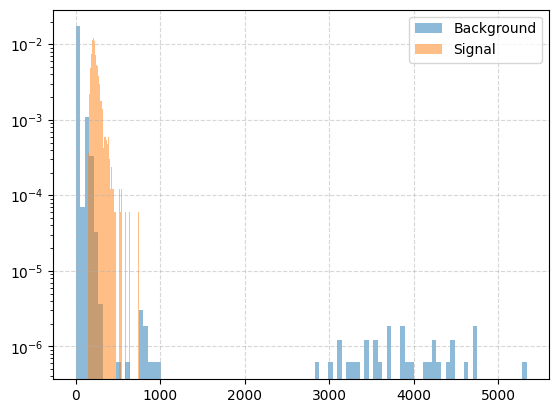

In [38]:
plt.hist(loss[y_val == BKG], bins=100, density=True, alpha=0.5, label="Background")
plt.hist(loss[y_val == SIGNAL], bins=100, density=True, alpha=0.5, label="Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

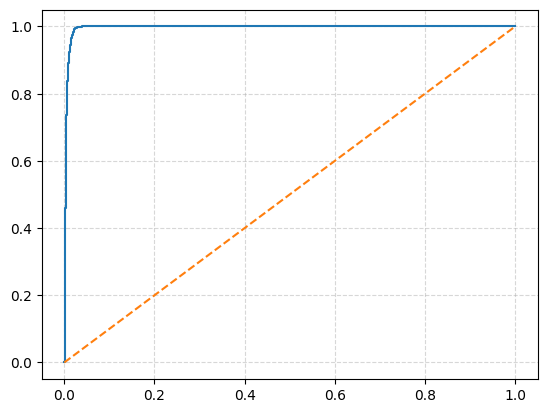

0.9953763384249212

In [39]:
fpr, tpr, _ = roc_curve(y_val, loss)#, sample_weight=W_val)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
roc_auc_score(y_val, loss)

## In Pytorch Lightning

In [25]:
import pytorch_lightning as pl
import torch.nn as nn

from torchmetrics import AUROC

In [26]:
from typing import List

class LitAutoEncoder(pl.LightningModule):
    def __init__(self, input_dim: int, latent_dim: int, arch: List[int]):
            super().__init__()

            self.input_dim = input_dim
            self.latent_dim = latent_dim
            self.arch = arch

            self.training_step_outputs = []
            self.validation_step_outputs = []

            if len(arch) == 0:
                raise ValueError("Encoder architecture must have at least one layer")

            if latent_dim >= arch[-1]:
                raise ValueError("Latent dimension must be smaller than the last encoder layer")

            self.encoder = self._encoder()
            self.decoder = self._decoder()

    def _encoder(self) -> nn.Sequential:
        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.arch[0]),
            nn.ReLU()
        )

        for i in range(1, len(self.arch)):
            self.encoder.add_module(f"fc({i})", nn.Linear(self.arch[i - 1], self.arch[i]))
            self.encoder.add_module(f"A({i})", nn.ReLU())

        self.encoder.add_module(f"A({i+1})", nn.ReLU())
        self.encoder.add_module("encoder_output", nn.Linear(self.arch[-1], self.latent_dim))

        return self.encoder

    def _decoder(self) -> nn.Sequential:
        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.arch[-1]),
            nn.ReLU()
        )

        for i in range(len(self.arch) - 1, 0, -1):
            self.decoder.add_module(f"fc({i})", nn.Linear(self.arch[i], self.arch[i - 1]))
            self.decoder.add_module(f"A({i})", nn.ReLU())

        self.decoder.add_module("decoder_output", nn.Linear(self.arch[0], self.input_dim))

        return self.decoder

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def training_step(self, batch, batch_idx):
        X, _, w = batch

        X_preds = self(X)
        loss = torch.einsum('ij,i->ij', torch.abs(X_preds - X), w).sum()
        self.training_step_outputs.append(loss)
        return loss

    def on_train_epoch_end(self) -> None:
        loss = torch.stack(self.training_step_outputs)
        self.log('training_loss', loss.mean())
        self.training_step_outputs.clear()

    def validation_step(self, batch, batch_idx):
        X, _, w = batch

        X_preds = self(X)
        loss = torch.einsum('ij,i->ij', torch.abs(X_preds - X), w).sum()
        self.validation_step_outputs.append(loss)
        return loss

    def on_validation_epoch_end(self) -> None:
        loss = torch.stack(self.validation_step_outputs)
        self.log('val_loss', loss.mean())
        self.validation_step_outputs.clear()


NameError: name 'pl' is not defined

In [35]:
callbacks = [
    pl.callbacks.EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.001, verbose=True),
    pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, verbose=True, filename='ae_best'),
    pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
]

ae_trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=1000,
    callbacks=callbacks,
    default_root_dir='logs',
    logger=pl.loggers.TensorBoardLogger('logs/', name='ae'),
    log_every_n_steps=30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
ae_model = LitAutoEncoder(X_train.shape[1], 6, [64, 32, 16, 8])
ae_trainer.fit(ae_model, ae_train_loader, ae_val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 5.9 K 
1 | decoder | Sequential | 5.9 K 
---------------------------------------
11.8 K    Trainable params
0         Non-trainable params
11.8 K    Total params
0.047     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: 100%|██████████| 30/30 [00:01<00:00, 25.67it/s, v_num=5]          

Metric val_loss improved. New best score: 19909.013
Epoch 0, global step 30: 'val_loss' reached 19909.01277 (best 19909.01277), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 1: 100%|██████████| 30/30 [00:01<00:00, 24.10it/s, v_num=5]

Metric val_loss improved by 813.465 >= min_delta = 0.001. New best score: 19095.547
Epoch 1, global step 60: 'val_loss' reached 19095.54738 (best 19095.54738), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 2: 100%|██████████| 30/30 [00:01<00:00, 24.71it/s, v_num=5]

Metric val_loss improved by 654.130 >= min_delta = 0.001. New best score: 18441.417
Epoch 2, global step 90: 'val_loss' reached 18441.41733 (best 18441.41733), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 3: 100%|██████████| 30/30 [00:01<00:00, 23.48it/s, v_num=5]

Metric val_loss improved by 612.611 >= min_delta = 0.001. New best score: 17828.806
Epoch 3, global step 120: 'val_loss' reached 17828.80633 (best 17828.80633), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 4: 100%|██████████| 30/30 [00:01<00:00, 24.29it/s, v_num=5]

Metric val_loss improved by 217.863 >= min_delta = 0.001. New best score: 17610.943
Epoch 4, global step 150: 'val_loss' reached 17610.94335 (best 17610.94335), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 5: 100%|██████████| 30/30 [00:01<00:00, 23.27it/s, v_num=5]

Metric val_loss improved by 119.800 >= min_delta = 0.001. New best score: 17491.143
Epoch 5, global step 180: 'val_loss' reached 17491.14325 (best 17491.14325), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 6: 100%|██████████| 30/30 [00:01<00:00, 23.70it/s, v_num=5]

Metric val_loss improved by 113.080 >= min_delta = 0.001. New best score: 17378.063
Epoch 6, global step 210: 'val_loss' reached 17378.06326 (best 17378.06326), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 7: 100%|██████████| 30/30 [00:01<00:00, 23.46it/s, v_num=5]

Metric val_loss improved by 153.242 >= min_delta = 0.001. New best score: 17224.821
Epoch 7, global step 240: 'val_loss' reached 17224.82084 (best 17224.82084), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 8: 100%|██████████| 30/30 [00:01<00:00, 23.23it/s, v_num=5]

Metric val_loss improved by 584.510 >= min_delta = 0.001. New best score: 16640.311
Epoch 8, global step 270: 'val_loss' reached 16640.31080 (best 16640.31080), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 9: 100%|██████████| 30/30 [00:01<00:00, 23.96it/s, v_num=5]

Metric val_loss improved by 379.178 >= min_delta = 0.001. New best score: 16261.132
Epoch 9, global step 300: 'val_loss' reached 16261.13241 (best 16261.13241), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 10: 100%|██████████| 30/30 [00:01<00:00, 22.84it/s, v_num=5]

Metric val_loss improved by 17.907 >= min_delta = 0.001. New best score: 16243.225
Epoch 10, global step 330: 'val_loss' reached 16243.22541 (best 16243.22541), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 11: 100%|██████████| 30/30 [00:01<00:00, 23.10it/s, v_num=5]

Metric val_loss improved by 116.831 >= min_delta = 0.001. New best score: 16126.394
Epoch 11, global step 360: 'val_loss' reached 16126.39408 (best 16126.39408), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 12: 100%|██████████| 30/30 [00:01<00:00, 23.90it/s, v_num=5]

Metric val_loss improved by 117.458 >= min_delta = 0.001. New best score: 16008.936
Epoch 12, global step 390: 'val_loss' reached 16008.93615 (best 16008.93615), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 13: 100%|██████████| 30/30 [00:01<00:00, 24.43it/s, v_num=5]

Metric val_loss improved by 56.747 >= min_delta = 0.001. New best score: 15952.189
Epoch 13, global step 420: 'val_loss' reached 15952.18877 (best 15952.18877), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 14: 100%|██████████| 30/30 [00:01<00:00, 21.35it/s, v_num=5]

Metric val_loss improved by 0.970 >= min_delta = 0.001. New best score: 15951.219
Epoch 14, global step 450: 'val_loss' reached 15951.21886 (best 15951.21886), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 15: 100%|██████████| 30/30 [00:01<00:00, 23.33it/s, v_num=5]

Metric val_loss improved by 22.454 >= min_delta = 0.001. New best score: 15928.764
Epoch 15, global step 480: 'val_loss' reached 15928.76439 (best 15928.76439), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 16: 100%|██████████| 30/30 [00:01<00:00, 23.89it/s, v_num=5]

Metric val_loss improved by 41.730 >= min_delta = 0.001. New best score: 15887.034
Epoch 16, global step 510: 'val_loss' reached 15887.03392 (best 15887.03392), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 17: 100%|██████████| 30/30 [00:01<00:00, 24.48it/s, v_num=5]

Metric val_loss improved by 7.306 >= min_delta = 0.001. New best score: 15879.728
Epoch 17, global step 540: 'val_loss' reached 15879.72820 (best 15879.72820), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 18: 100%|██████████| 30/30 [00:01<00:00, 22.10it/s, v_num=5]

Metric val_loss improved by 34.322 >= min_delta = 0.001. New best score: 15845.406
Epoch 18, global step 570: 'val_loss' reached 15845.40617 (best 15845.40617), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 19: 100%|██████████| 30/30 [00:01<00:00, 24.31it/s, v_num=5]

Metric val_loss improved by 13.773 >= min_delta = 0.001. New best score: 15831.633
Epoch 19, global step 600: 'val_loss' reached 15831.63311 (best 15831.63311), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 20: 100%|██████████| 30/30 [00:01<00:00, 23.45it/s, v_num=5]

Metric val_loss improved by 9.845 >= min_delta = 0.001. New best score: 15821.788
Epoch 20, global step 630: 'val_loss' reached 15821.78808 (best 15821.78808), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 21: 100%|██████████| 30/30 [00:01<00:00, 23.86it/s, v_num=5]

Epoch 21, global step 660: 'val_loss' was not in top 1


Epoch 22: 100%|██████████| 30/30 [00:01<00:00, 24.87it/s, v_num=5]

Metric val_loss improved by 25.756 >= min_delta = 0.001. New best score: 15796.032
Epoch 22, global step 690: 'val_loss' reached 15796.03210 (best 15796.03210), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 23: 100%|██████████| 30/30 [00:01<00:00, 23.70it/s, v_num=5]

Epoch 23, global step 720: 'val_loss' was not in top 1


Epoch 24: 100%|██████████| 30/30 [00:01<00:00, 23.56it/s, v_num=5]

Metric val_loss improved by 14.787 >= min_delta = 0.001. New best score: 15781.246
Epoch 24, global step 750: 'val_loss' reached 15781.24551 (best 15781.24551), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 25: 100%|██████████| 30/30 [00:01<00:00, 21.65it/s, v_num=5]

Metric val_loss improved by 5.463 >= min_delta = 0.001. New best score: 15775.783
Epoch 25, global step 780: 'val_loss' reached 15775.78298 (best 15775.78298), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 26: 100%|██████████| 30/30 [00:01<00:00, 22.92it/s, v_num=5]

Metric val_loss improved by 44.386 >= min_delta = 0.001. New best score: 15731.397
Epoch 26, global step 810: 'val_loss' reached 15731.39651 (best 15731.39651), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 27: 100%|██████████| 30/30 [00:01<00:00, 23.64it/s, v_num=5]

Metric val_loss improved by 29.578 >= min_delta = 0.001. New best score: 15701.819
Epoch 27, global step 840: 'val_loss' reached 15701.81874 (best 15701.81874), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 28: 100%|██████████| 30/30 [00:01<00:00, 23.48it/s, v_num=5]

Metric val_loss improved by 88.723 >= min_delta = 0.001. New best score: 15613.096
Epoch 28, global step 870: 'val_loss' reached 15613.09566 (best 15613.09566), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 29: 100%|██████████| 30/30 [00:01<00:00, 23.62it/s, v_num=5]

Metric val_loss improved by 168.165 >= min_delta = 0.001. New best score: 15444.930
Epoch 29, global step 900: 'val_loss' reached 15444.93022 (best 15444.93022), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 30: 100%|██████████| 30/30 [00:01<00:00, 24.12it/s, v_num=5]

Metric val_loss improved by 139.638 >= min_delta = 0.001. New best score: 15305.292
Epoch 30, global step 930: 'val_loss' reached 15305.29195 (best 15305.29195), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 31: 100%|██████████| 30/30 [00:01<00:00, 24.07it/s, v_num=5]

Metric val_loss improved by 113.225 >= min_delta = 0.001. New best score: 15192.067
Epoch 31, global step 960: 'val_loss' reached 15192.06677 (best 15192.06677), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 32: 100%|██████████| 30/30 [00:01<00:00, 23.17it/s, v_num=5]

Metric val_loss improved by 40.690 >= min_delta = 0.001. New best score: 15151.376
Epoch 32, global step 990: 'val_loss' reached 15151.37648 (best 15151.37648), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 33: 100%|██████████| 30/30 [00:01<00:00, 24.24it/s, v_num=5]

Metric val_loss improved by 52.110 >= min_delta = 0.001. New best score: 15099.266
Epoch 33, global step 1020: 'val_loss' reached 15099.26639 (best 15099.26639), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 34: 100%|██████████| 30/30 [00:01<00:00, 21.79it/s, v_num=5]

Metric val_loss improved by 9.283 >= min_delta = 0.001. New best score: 15089.983
Epoch 34, global step 1050: 'val_loss' reached 15089.98310 (best 15089.98310), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 35: 100%|██████████| 30/30 [00:01<00:00, 21.30it/s, v_num=5]

Metric val_loss improved by 40.399 >= min_delta = 0.001. New best score: 15049.585
Epoch 35, global step 1080: 'val_loss' reached 15049.58458 (best 15049.58458), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 36: 100%|██████████| 30/30 [00:01<00:00, 23.13it/s, v_num=5]

Metric val_loss improved by 11.506 >= min_delta = 0.001. New best score: 15038.078
Epoch 36, global step 1110: 'val_loss' reached 15038.07830 (best 15038.07830), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 37: 100%|██████████| 30/30 [00:01<00:00, 23.56it/s, v_num=5]

Metric val_loss improved by 24.672 >= min_delta = 0.001. New best score: 15013.406
Epoch 37, global step 1140: 'val_loss' reached 15013.40602 (best 15013.40602), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 38: 100%|██████████| 30/30 [00:01<00:00, 24.48it/s, v_num=5]

Epoch 38, global step 1170: 'val_loss' was not in top 1


Epoch 39: 100%|██████████| 30/30 [00:01<00:00, 23.31it/s, v_num=5]

Metric val_loss improved by 31.555 >= min_delta = 0.001. New best score: 14981.851
Epoch 39, global step 1200: 'val_loss' reached 14981.85109 (best 14981.85109), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 40: 100%|██████████| 30/30 [00:01<00:00, 24.22it/s, v_num=5]

Epoch 40, global step 1230: 'val_loss' was not in top 1


Epoch 41: 100%|██████████| 30/30 [00:01<00:00, 22.63it/s, v_num=5]

Metric val_loss improved by 14.825 >= min_delta = 0.001. New best score: 14967.026
Epoch 41, global step 1260: 'val_loss' reached 14967.02589 (best 14967.02589), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 42: 100%|██████████| 30/30 [00:01<00:00, 24.71it/s, v_num=5]

Metric val_loss improved by 3.178 >= min_delta = 0.001. New best score: 14963.848
Epoch 42, global step 1290: 'val_loss' reached 14963.84806 (best 14963.84806), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 43: 100%|██████████| 30/30 [00:01<00:00, 22.82it/s, v_num=5]

Metric val_loss improved by 39.801 >= min_delta = 0.001. New best score: 14924.047
Epoch 43, global step 1320: 'val_loss' reached 14924.04685 (best 14924.04685), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 44: 100%|██████████| 30/30 [00:01<00:00, 23.53it/s, v_num=5]

Metric val_loss improved by 1.393 >= min_delta = 0.001. New best score: 14922.654
Epoch 44, global step 1350: 'val_loss' reached 14922.65371 (best 14922.65371), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 45: 100%|██████████| 30/30 [00:01<00:00, 24.59it/s, v_num=5]

Metric val_loss improved by 14.778 >= min_delta = 0.001. New best score: 14907.875
Epoch 45, global step 1380: 'val_loss' reached 14907.87529 (best 14907.87529), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 46: 100%|██████████| 30/30 [00:01<00:00, 24.38it/s, v_num=5]

Epoch 46, global step 1410: 'val_loss' was not in top 1


Epoch 47: 100%|██████████| 30/30 [00:01<00:00, 23.30it/s, v_num=5]

Metric val_loss improved by 21.587 >= min_delta = 0.001. New best score: 14886.289
Epoch 47, global step 1440: 'val_loss' reached 14886.28867 (best 14886.28867), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 48: 100%|██████████| 30/30 [00:01<00:00, 24.65it/s, v_num=5]

Epoch 48, global step 1470: 'val_loss' was not in top 1


Epoch 49: 100%|██████████| 30/30 [00:01<00:00, 24.69it/s, v_num=5]

Metric val_loss improved by 10.316 >= min_delta = 0.001. New best score: 14875.973
Epoch 49, global step 1500: 'val_loss' reached 14875.97295 (best 14875.97295), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 50: 100%|██████████| 30/30 [00:01<00:00, 23.39it/s, v_num=5]

Epoch 50, global step 1530: 'val_loss' was not in top 1


Epoch 51: 100%|██████████| 30/30 [00:01<00:00, 24.05it/s, v_num=5]

Metric val_loss improved by 4.395 >= min_delta = 0.001. New best score: 14871.578
Epoch 51, global step 1560: 'val_loss' reached 14871.57833 (best 14871.57833), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 52: 100%|██████████| 30/30 [00:01<00:00, 24.55it/s, v_num=5]

Epoch 52, global step 1590: 'val_loss' was not in top 1


Epoch 53: 100%|██████████| 30/30 [00:01<00:00, 22.74it/s, v_num=5]

Metric val_loss improved by 3.638 >= min_delta = 0.001. New best score: 14867.940
Epoch 53, global step 1620: 'val_loss' reached 14867.94025 (best 14867.94025), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 54: 100%|██████████| 30/30 [00:01<00:00, 23.35it/s, v_num=5]

Metric val_loss improved by 4.136 >= min_delta = 0.001. New best score: 14863.804
Epoch 54, global step 1650: 'val_loss' reached 14863.80395 (best 14863.80395), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 55: 100%|██████████| 30/30 [00:01<00:00, 22.14it/s, v_num=5]

Epoch 55, global step 1680: 'val_loss' was not in top 1


Epoch 56: 100%|██████████| 30/30 [00:01<00:00, 22.04it/s, v_num=5]

Epoch 56, global step 1710: 'val_loss' was not in top 1


Epoch 57: 100%|██████████| 30/30 [00:01<00:00, 23.54it/s, v_num=5]

Metric val_loss improved by 14.169 >= min_delta = 0.001. New best score: 14849.635
Epoch 57, global step 1740: 'val_loss' reached 14849.63523 (best 14849.63523), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 58: 100%|██████████| 30/30 [00:01<00:00, 23.73it/s, v_num=5]

Epoch 58, global step 1770: 'val_loss' was not in top 1


Epoch 59: 100%|██████████| 30/30 [00:01<00:00, 23.01it/s, v_num=5]

Epoch 59, global step 1800: 'val_loss' was not in top 1


Epoch 60: 100%|██████████| 30/30 [00:01<00:00, 23.69it/s, v_num=5]

Metric val_loss improved by 24.792 >= min_delta = 0.001. New best score: 14824.843
Epoch 60, global step 1830: 'val_loss' reached 14824.84275 (best 14824.84275), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 61: 100%|██████████| 30/30 [00:01<00:00, 23.30it/s, v_num=5]

Epoch 61, global step 1860: 'val_loss' was not in top 1


Epoch 62: 100%|██████████| 30/30 [00:01<00:00, 24.75it/s, v_num=5]

Epoch 62, global step 1890: 'val_loss' was not in top 1


Epoch 63: 100%|██████████| 30/30 [00:01<00:00, 23.27it/s, v_num=5]

Epoch 63, global step 1920: 'val_loss' was not in top 1


Epoch 64: 100%|██████████| 30/30 [00:01<00:00, 24.10it/s, v_num=5]

Epoch 64, global step 1950: 'val_loss' was not in top 1


Epoch 65: 100%|██████████| 30/30 [00:01<00:00, 24.27it/s, v_num=5]

Metric val_loss improved by 23.041 >= min_delta = 0.001. New best score: 14801.802
Epoch 65, global step 1980: 'val_loss' reached 14801.80183 (best 14801.80183), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 66: 100%|██████████| 30/30 [00:01<00:00, 24.21it/s, v_num=5]

Epoch 66, global step 2010: 'val_loss' was not in top 1


Epoch 67: 100%|██████████| 30/30 [00:01<00:00, 22.83it/s, v_num=5]

Epoch 67, global step 2040: 'val_loss' was not in top 1


Epoch 68: 100%|██████████| 30/30 [00:01<00:00, 22.59it/s, v_num=5]

Epoch 68, global step 2070: 'val_loss' was not in top 1


Epoch 69: 100%|██████████| 30/30 [00:01<00:00, 24.18it/s, v_num=5]

Metric val_loss improved by 33.808 >= min_delta = 0.001. New best score: 14767.994
Epoch 69, global step 2100: 'val_loss' reached 14767.99404 (best 14767.99404), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 70: 100%|██████████| 30/30 [00:01<00:00, 24.17it/s, v_num=5]

Epoch 70, global step 2130: 'val_loss' was not in top 1


Epoch 71: 100%|██████████| 30/30 [00:01<00:00, 22.93it/s, v_num=5]

Epoch 71, global step 2160: 'val_loss' was not in top 1


Epoch 72: 100%|██████████| 30/30 [00:01<00:00, 24.29it/s, v_num=5]

Epoch 72, global step 2190: 'val_loss' was not in top 1


Epoch 73: 100%|██████████| 30/30 [00:01<00:00, 23.58it/s, v_num=5]

Epoch 73, global step 2220: 'val_loss' was not in top 1


Epoch 74: 100%|██████████| 30/30 [00:01<00:00, 23.52it/s, v_num=5]

Metric val_loss improved by 3.689 >= min_delta = 0.001. New best score: 14764.305
Epoch 74, global step 2250: 'val_loss' reached 14764.30549 (best 14764.30549), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 75: 100%|██████████| 30/30 [00:01<00:00, 23.62it/s, v_num=5]

Epoch 75, global step 2280: 'val_loss' was not in top 1


Epoch 76: 100%|██████████| 30/30 [00:01<00:00, 24.06it/s, v_num=5]

Metric val_loss improved by 12.827 >= min_delta = 0.001. New best score: 14751.478
Epoch 76, global step 2310: 'val_loss' reached 14751.47805 (best 14751.47805), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 77: 100%|██████████| 30/30 [00:01<00:00, 23.74it/s, v_num=5]

Metric val_loss improved by 3.239 >= min_delta = 0.001. New best score: 14748.239
Epoch 77, global step 2340: 'val_loss' reached 14748.23950 (best 14748.23950), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 78: 100%|██████████| 30/30 [00:01<00:00, 24.32it/s, v_num=5]

Epoch 78, global step 2370: 'val_loss' was not in top 1


Epoch 79: 100%|██████████| 30/30 [00:01<00:00, 24.67it/s, v_num=5]

Epoch 79, global step 2400: 'val_loss' was not in top 1


Epoch 80: 100%|██████████| 30/30 [00:01<00:00, 24.74it/s, v_num=5]

Metric val_loss improved by 4.488 >= min_delta = 0.001. New best score: 14743.752
Epoch 80, global step 2430: 'val_loss' reached 14743.75186 (best 14743.75186), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 81: 100%|██████████| 30/30 [00:01<00:00, 24.14it/s, v_num=5]

Epoch 81, global step 2460: 'val_loss' was not in top 1


Epoch 82: 100%|██████████| 30/30 [00:01<00:00, 23.19it/s, v_num=5]

Metric val_loss improved by 19.067 >= min_delta = 0.001. New best score: 14724.685
Epoch 82, global step 2490: 'val_loss' reached 14724.68453 (best 14724.68453), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 83: 100%|██████████| 30/30 [00:01<00:00, 23.94it/s, v_num=5]

Epoch 83, global step 2520: 'val_loss' was not in top 1


Epoch 84: 100%|██████████| 30/30 [00:01<00:00, 22.86it/s, v_num=5]

Epoch 84, global step 2550: 'val_loss' was not in top 1


Epoch 85: 100%|██████████| 30/30 [00:01<00:00, 25.31it/s, v_num=5]

Metric val_loss improved by 22.091 >= min_delta = 0.001. New best score: 14702.594
Epoch 85, global step 2580: 'val_loss' reached 14702.59368 (best 14702.59368), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 86: 100%|██████████| 30/30 [00:01<00:00, 23.26it/s, v_num=5]

Epoch 86, global step 2610: 'val_loss' was not in top 1


Epoch 87: 100%|██████████| 30/30 [00:01<00:00, 24.22it/s, v_num=5]

Epoch 87, global step 2640: 'val_loss' was not in top 1


Epoch 88: 100%|██████████| 30/30 [00:01<00:00, 23.68it/s, v_num=5]

Epoch 88, global step 2670: 'val_loss' was not in top 1


Epoch 89: 100%|██████████| 30/30 [00:01<00:00, 23.82it/s, v_num=5]

Epoch 89, global step 2700: 'val_loss' was not in top 1


Epoch 90: 100%|██████████| 30/30 [00:01<00:00, 24.23it/s, v_num=5]

Epoch 90, global step 2730: 'val_loss' was not in top 1


Epoch 91: 100%|██████████| 30/30 [00:01<00:00, 24.18it/s, v_num=5]

Epoch 91, global step 2760: 'val_loss' was not in top 1


Epoch 00092: reducing learning rate of group 0 to 1.0000e-04.
Epoch 92: 100%|██████████| 30/30 [00:01<00:00, 24.34it/s, v_num=5]

Metric val_loss improved by 43.314 >= min_delta = 0.001. New best score: 14659.279
Epoch 92, global step 2790: 'val_loss' reached 14659.27922 (best 14659.27922), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 93: 100%|██████████| 30/30 [00:01<00:00, 23.85it/s, v_num=5]

Metric val_loss improved by 8.574 >= min_delta = 0.001. New best score: 14650.705
Epoch 93, global step 2820: 'val_loss' reached 14650.70532 (best 14650.70532), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 94: 100%|██████████| 30/30 [00:01<00:00, 24.12it/s, v_num=5]

Metric val_loss improved by 2.282 >= min_delta = 0.001. New best score: 14648.423
Epoch 94, global step 2850: 'val_loss' reached 14648.42312 (best 14648.42312), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 95: 100%|██████████| 30/30 [00:01<00:00, 23.84it/s, v_num=5]

Metric val_loss improved by 1.406 >= min_delta = 0.001. New best score: 14647.018
Epoch 95, global step 2880: 'val_loss' reached 14647.01756 (best 14647.01756), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 96: 100%|██████████| 30/30 [00:01<00:00, 23.81it/s, v_num=5]

Epoch 96, global step 2910: 'val_loss' was not in top 1


Epoch 97: 100%|██████████| 30/30 [00:01<00:00, 23.56it/s, v_num=5]

Metric val_loss improved by 4.384 >= min_delta = 0.001. New best score: 14642.633
Epoch 97, global step 2940: 'val_loss' reached 14642.63317 (best 14642.63317), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 98: 100%|██████████| 30/30 [00:01<00:00, 23.73it/s, v_num=5]

Epoch 98, global step 2970: 'val_loss' was not in top 1


Epoch 99: 100%|██████████| 30/30 [00:01<00:00, 24.31it/s, v_num=5]

Epoch 99, global step 3000: 'val_loss' was not in top 1


Epoch 100: 100%|██████████| 30/30 [00:01<00:00, 23.85it/s, v_num=5]

Metric val_loss improved by 1.085 >= min_delta = 0.001. New best score: 14641.549
Epoch 100, global step 3030: 'val_loss' reached 14641.54860 (best 14641.54860), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 101: 100%|██████████| 30/30 [00:01<00:00, 24.30it/s, v_num=5]

Epoch 101, global step 3060: 'val_loss' was not in top 1


Epoch 102: 100%|██████████| 30/30 [00:01<00:00, 24.35it/s, v_num=5]

Epoch 102, global step 3090: 'val_loss' was not in top 1


Epoch 103: 100%|██████████| 30/30 [00:01<00:00, 25.13it/s, v_num=5]

Epoch 103, global step 3120: 'val_loss' was not in top 1


Epoch 00104: reducing learning rate of group 0 to 1.0000e-05.
Epoch 104: 100%|██████████| 30/30 [00:01<00:00, 23.63it/s, v_num=5]

Epoch 104, global step 3150: 'val_loss' was not in top 1


Epoch 105: 100%|██████████| 30/30 [00:01<00:00, 23.43it/s, v_num=5]

Metric val_loss improved by 0.061 >= min_delta = 0.001. New best score: 14641.488
Epoch 105, global step 3180: 'val_loss' reached 14641.48779 (best 14641.48779), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 106: 100%|██████████| 30/30 [00:01<00:00, 22.95it/s, v_num=5]

Metric val_loss improved by 0.183 >= min_delta = 0.001. New best score: 14641.305
Epoch 106, global step 3210: 'val_loss' reached 14641.30493 (best 14641.30493), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 107: 100%|██████████| 30/30 [00:01<00:00, 24.86it/s, v_num=5]

Metric val_loss improved by 0.544 >= min_delta = 0.001. New best score: 14640.761
Epoch 107, global step 3240: 'val_loss' reached 14640.76070 (best 14640.76070), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 108: 100%|██████████| 30/30 [00:01<00:00, 23.48it/s, v_num=5]

Metric val_loss improved by 0.154 >= min_delta = 0.001. New best score: 14640.607
Epoch 108, global step 3270: 'val_loss' reached 14640.60650 (best 14640.60650), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 109: 100%|██████████| 30/30 [00:01<00:00, 23.75it/s, v_num=5]

Epoch 109, global step 3300: 'val_loss' was not in top 1


Epoch 110: 100%|██████████| 30/30 [00:01<00:00, 22.91it/s, v_num=5]

Metric val_loss improved by 0.422 >= min_delta = 0.001. New best score: 14640.184
Epoch 110, global step 3330: 'val_loss' reached 14640.18427 (best 14640.18427), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 111: 100%|██████████| 30/30 [00:01<00:00, 24.31it/s, v_num=5]

Epoch 111, global step 3360: 'val_loss' was not in top 1


Epoch 112: 100%|██████████| 30/30 [00:01<00:00, 23.84it/s, v_num=5]

Metric val_loss improved by 0.193 >= min_delta = 0.001. New best score: 14639.991
Epoch 112, global step 3390: 'val_loss' reached 14639.99140 (best 14639.99140), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 113: 100%|██████████| 30/30 [00:01<00:00, 24.80it/s, v_num=5]

Epoch 113, global step 3420: 'val_loss' was not in top 1


Epoch 00114: reducing learning rate of group 0 to 1.0000e-06.
Epoch 114: 100%|██████████| 30/30 [00:01<00:00, 24.39it/s, v_num=5]

Metric val_loss improved by 0.027 >= min_delta = 0.001. New best score: 14639.964
Epoch 114, global step 3450: 'val_loss' reached 14639.96403 (best 14639.96403), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 115: 100%|██████████| 30/30 [00:01<00:00, 22.45it/s, v_num=5]

Metric val_loss improved by 0.047 >= min_delta = 0.001. New best score: 14639.917
Epoch 115, global step 3480: 'val_loss' reached 14639.91746 (best 14639.91746), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 116: 100%|██████████| 30/30 [00:01<00:00, 24.43it/s, v_num=5]

Metric val_loss improved by 0.038 >= min_delta = 0.001. New best score: 14639.880
Epoch 116, global step 3510: 'val_loss' reached 14639.87987 (best 14639.87987), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 117: 100%|██████████| 30/30 [00:01<00:00, 23.00it/s, v_num=5]

Metric val_loss improved by 0.045 >= min_delta = 0.001. New best score: 14639.835
Epoch 117, global step 3540: 'val_loss' reached 14639.83456 (best 14639.83456), saving model to 'logs/ae/version_5/checkpoints/ae_best.ckpt' as top 1


Epoch 118: 100%|██████████| 30/30 [00:01<00:00, 24.00it/s, v_num=5]

Epoch 118, global step 3570: 'val_loss' was not in top 1


Epoch 119: 100%|██████████| 30/30 [00:01<00:00, 23.76it/s, v_num=5]

Epoch 119, global step 3600: 'val_loss' was not in top 1


Epoch 00120: reducing learning rate of group 0 to 1.0000e-07.
Epoch 120: 100%|██████████| 30/30 [00:01<00:00, 24.10it/s, v_num=5]

Epoch 120, global step 3630: 'val_loss' was not in top 1


Epoch 121: 100%|██████████| 30/30 [00:01<00:00, 24.42it/s, v_num=5]

Epoch 121, global step 3660: 'val_loss' was not in top 1


Epoch 122: 100%|██████████| 30/30 [00:01<00:00, 25.46it/s, v_num=5]

Epoch 122, global step 3690: 'val_loss' was not in top 1


Epoch 123: 100%|██████████| 30/30 [00:01<00:00, 24.13it/s, v_num=5]

Epoch 123, global step 3720: 'val_loss' was not in top 1


Epoch 124: 100%|██████████| 30/30 [00:01<00:00, 24.08it/s, v_num=5]

Epoch 124, global step 3750: 'val_loss' was not in top 1


Epoch 125: 100%|██████████| 30/30 [00:01<00:00, 24.35it/s, v_num=5]

Epoch 125, global step 3780: 'val_loss' was not in top 1


Epoch 00126: reducing learning rate of group 0 to 1.0000e-08.
Epoch 126: 100%|██████████| 30/30 [00:01<00:00, 24.69it/s, v_num=5]

Epoch 126, global step 3810: 'val_loss' was not in top 1


Epoch 127: 100%|██████████| 30/30 [00:01<00:00, 23.44it/s, v_num=5]

Epoch 127, global step 3840: 'val_loss' was not in top 1


Epoch 128: 100%|██████████| 30/30 [00:01<00:00, 24.25it/s, v_num=5]

Epoch 128, global step 3870: 'val_loss' was not in top 1


Epoch 129: 100%|██████████| 30/30 [00:01<00:00, 24.15it/s, v_num=5]

Epoch 129, global step 3900: 'val_loss' was not in top 1


Epoch 130: 100%|██████████| 30/30 [00:01<00:00, 24.18it/s, v_num=5]

Epoch 130, global step 3930: 'val_loss' was not in top 1


Epoch 131: 100%|██████████| 30/30 [00:01<00:00, 24.24it/s, v_num=5]

Epoch 131, global step 3960: 'val_loss' was not in top 1


Epoch 132: 100%|██████████| 30/30 [00:01<00:00, 23.68it/s, v_num=5]

Epoch 132, global step 3990: 'val_loss' was not in top 1


Epoch 133: 100%|██████████| 30/30 [00:01<00:00, 24.76it/s, v_num=5]

Epoch 133, global step 4020: 'val_loss' was not in top 1


Epoch 134: 100%|██████████| 30/30 [00:01<00:00, 24.04it/s, v_num=5]

Epoch 134, global step 4050: 'val_loss' was not in top 1


Epoch 135: 100%|██████████| 30/30 [00:01<00:00, 24.04it/s, v_num=5]

Epoch 135, global step 4080: 'val_loss' was not in top 1


Epoch 136: 100%|██████████| 30/30 [00:01<00:00, 25.18it/s, v_num=5]

Epoch 136, global step 4110: 'val_loss' was not in top 1


Epoch 137: 100%|██████████| 30/30 [00:01<00:00, 23.59it/s, v_num=5]

Epoch 137, global step 4140: 'val_loss' was not in top 1


Epoch 138: 100%|██████████| 30/30 [00:01<00:00, 24.50it/s, v_num=5]

Epoch 138, global step 4170: 'val_loss' was not in top 1


Epoch 139: 100%|██████████| 30/30 [00:01<00:00, 23.67it/s, v_num=5]

Epoch 139, global step 4200: 'val_loss' was not in top 1


Epoch 140: 100%|██████████| 30/30 [00:01<00:00, 23.80it/s, v_num=5]

Epoch 140, global step 4230: 'val_loss' was not in top 1


Epoch 141: 100%|██████████| 30/30 [00:01<00:00, 24.25it/s, v_num=5]

Epoch 141, global step 4260: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 30/30 [00:01<00:00, 24.01it/s, v_num=5]

Monitored metric val_loss did not improve in the last 25 records. Best score: 14639.835. Signaling Trainer to stop.
Epoch 142, global step 4290: 'val_loss' was not in top 1


Epoch 142: 100%|██████████| 30/30 [00:01<00:00, 23.88it/s, v_num=5]


In [29]:
print(X_val.shape, y_val.shape, W_val.shape)

df_val = pd.DataFrame(X_val, columns=features)
df_val.head()

(33333, 47) (33333,) (33333,)


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
0,-0.861531,0.707040,1.834103,2.713935,0.549560,0.438156,0.773991,0.133431,0.003153,-0.123851,...,0.723582,3.018843,0.531446,0.493900,0.393066,0.665883,4.229605,-1.099570,1.881434,1.840378
1,0.201022,-0.509772,0.552497,-0.317689,1.219077,-0.056018,-0.783480,-0.846994,-0.862099,-0.879337,...,-0.555954,0.440644,1.277099,-0.233800,-0.357823,0.891786,-0.874502,-0.880855,0.820695,0.422776
2,1.263575,1.050506,0.899676,-0.772240,1.485154,0.791478,-0.266721,-0.318604,-0.449653,-0.481598,...,0.976244,-0.224869,1.367246,1.173231,0.051313,-1.693614,-0.449634,0.306186,-1.300784,-1.032057
3,1.263575,1.483801,0.036739,-0.671481,-1.590941,0.338694,1.605887,2.106680,2.423242,2.581100,...,-0.016436,-1.057522,0.457641,-0.231023,-0.327456,1.177462,-0.441918,-0.510263,-0.240044,-0.624108
4,1.263575,1.070681,0.712604,2.604909,-0.194666,0.348125,-0.800600,-0.939690,-0.973314,-0.938744,...,1.166216,2.437919,-0.194765,0.877542,1.924162,-0.198418,2.267726,1.423036,-1.300784,1.863904


In [46]:
# load from logs/ae/version_5/checkpoints/ae_best.ckpt
ae_model = LitAutoEncoder.load_from_checkpoint('/home/fabiocfabini/Desktop/CS/LIPInternship/logs/ae/version_5/checkpoints/ae_best.ckpt', input_dim=X_train.shape[1], latent_dim=6, arch=[64, 32, 16, 8])

ae_model = ae_model.to(DEVICE)

ae_model.eval()
X_val_rec = []
with torch.no_grad():
    for batch, (X, _, _) in enumerate(val_loader):
        X = X.to(DEVICE)

        X_preds = ae_model(X)

        X_val_rec.append(X_preds.cpu().numpy())

X_val_rec = np.concatenate(X_val_rec)

In [47]:
X_val_rec.shape

df_val_rec = pd.DataFrame(X_val_rec, columns=features)
df_val_rec.head()

,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
0,-0.660842,0.069008,-0.477597,-0.698245,-0.175362,-0.603339,-0.041798,0.058478,0.075832,0.045342,...,0.125738,-0.679829,0.066207,0.044589,-0.610088,0.195692,-0.184735,0.225764,0.626307,-0.350189
1,1.103327,-0.481100,0.615829,-0.423998,0.677896,0.550385,-0.782513,-0.903860,-0.862801,-0.897562,...,-0.449289,0.084628,0.788366,-0.410218,0.143536,0.466016,-0.522941,-0.195855,-1.154945,-0.190813
2,0.898298,-0.273285,0.300976,-0.654145,0.007409,0.134709,-0.465225,-0.467182,-0.508271,-0.534077,...,-0.302262,-0.176618,0.639154,-0.364016,-0.060602,0.327933,-0.595655,-0.078249,-0.867497,-0.934829
3,-0.512173,0.081933,0.611374,-0.528944,0.386050,0.755342,1.919146,2.259585,2.346775,2.402849,...,-0.088356,-0.625910,-0.101526,0.198904,-0.487921,-0.118478,-0.250029,-0.303411,0.457804,-0.374256
4,0.849899,-0.312884,0.359680,-0.550922,0.380927,0.146752,-0.866767,-0.944126,-0.968723,-0.930992,...,-0.305632,0.200185,0.674625,-0.231472,0.089199,0.230767,-0.638004,-0.304866,-0.767578,-0.837457


In [48]:
loss = []
with torch.no_grad():
    for (X, _, w) in val_loader:
        X = X.to(DEVICE)
        w = w.to(DEVICE)

        X_preds = ae_model(X)

        loss.append(torch.einsum('ij,i->ij', torch.abs(X_preds - X), w).sum(dim=1))

loss = torch.cat(loss).cpu().numpy()

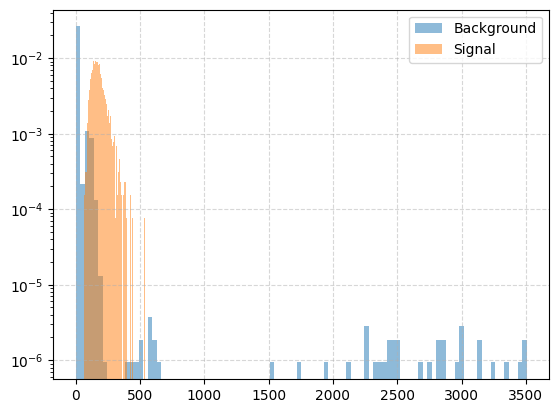

In [49]:
plt.hist(loss[y_val == BKG], bins=100, density=True, alpha=0.5, label="Background")
plt.hist(loss[y_val == SIGNAL], bins=100, density=True, alpha=0.5, label="Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

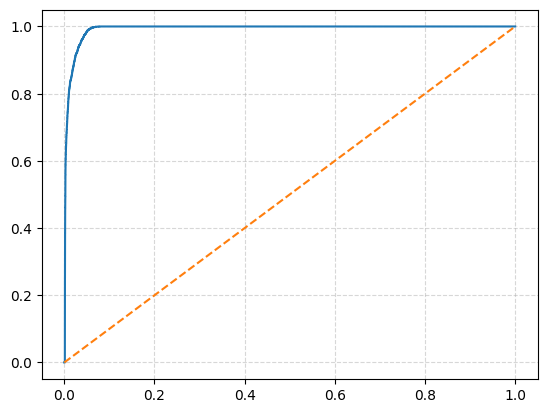

0.9923351803495757

In [50]:
fpr, tpr, _ = roc_curve(y_val, loss)#, sample_weight=W_val)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
roc_auc_score(y_val, loss)

## VAE

### Model

In [26]:
from typing import Literal, List

def mse_loss(input: torch.Tensor, target: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    return torch.einsum('ij,i->ij', (input - target)**2, weights).mean()

def mae_loss(input: torch.Tensor, target: torch.Tensor, weights: torch.Tensor) -> torch.Tensor:
    return torch.einsum('ij,i->ij', torch.abs(input - target), weights).mean()

class LitVariationaAutoEncoder(pl.LightningModule):
    def __init__(self, 
                input_dim: int,
                latent_dim: int, 
                arch: List[int], 
                rec_loss: Literal["mse", "mae"] = "mse", 
                rec_loss_weight: float = 1.0, 
                kl_loss_weight: float = 1.0, 
                lr_patience: int = 5
        ):
        super().__init__()

        self.arch = arch
        self.latent_dim = latent_dim
        self.input_dim = input_dim

        self.encoder = self._encoder()
        self.decoder = self._decoder()

        if rec_loss == "mse":
            self.rec_loss = mse_loss
        elif rec_loss == "mae":
            self.rec_loss = mae_loss
        else:
            raise ValueError("rec_loss must be one of ['mse', 'mae']")
        self.rec_loss_weight = rec_loss_weight
        self.kl_loss_weight = kl_loss_weight
        self.lr_patience = lr_patience

        self.train_rec_losses = []
        self.train_kl_losses = []
        self.val_losses = []

    def _encoder(self) -> nn.Sequential:
        """The encoder recieves [input_dim] features as input 
        and outputs [latent_dim * 2] features. It must 
        have the [arch] architecture.

        Returns:
            nn.Sequential: The encoder
        """

        self.encoder = nn.Sequential(
            nn.Linear(self.input_dim, self.arch[0]),
            nn.ReLU()
        )

        for i in range(1, len(self.arch)):
            self.encoder.add_module(f"fc({i})", nn.Linear(self.arch[i - 1], self.arch[i]))
            self.encoder.add_module(f"A({i})", nn.ReLU())

        self.encoder.add_module(f"A({i+1})", nn.ReLU())
        self.encoder.add_module("mu+sigma", nn.Linear(self.arch[-1], self.latent_dim * 2))

        return self.encoder

    def _decoder(self) -> nn.Sequential:
        """The decoder recieves [latent_dim] features
        as input and outputs [input_dim] features. It must have the
        [arch] architecture.

        Returns:
            nn.Sequential: The decoder
        """

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.arch[-1]),
            nn.ReLU()
        )

        for i in range(len(self.arch) - 1, 0, -1):
            self.decoder.add_module(f"fc({i})", nn.Linear(self.arch[i], self.arch[i - 1]))
            self.decoder.add_module(f"A({i})", nn.ReLU())

        self.decoder.add_module("decoder_output", nn.Linear(self.arch[0], self.input_dim))

        return self.decoder

    def _get_mu(self, mu_sigma: torch.Tensor) -> torch.Tensor:
        """Given the output of the encoder, returns the mu vector.

        Args:
            mu_sigma (torch.Tensor): The output of the encoder

        Returns:
            torch.Tensor: The mu vector
        """

        return mu_sigma[:, :self.latent_dim]

    def _get_sigma(self, mu_sigma: torch.Tensor) -> torch.Tensor:
        """Given the output of the encoder, returns the sigma vector.

        Args:
            mu_sigma (torch.Tensor): The output of the encoder

        Returns:
            torch.Tensor: The sigma vector
        """

        return mu_sigma[:, self.latent_dim:]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        mu_sigma = self.encoder(x)

        # Reparametrization trick
        epsilon = torch.randn_like(self._get_sigma(mu_sigma))
        z_new = self._get_mu(mu_sigma) + self._get_sigma(mu_sigma) * epsilon
        z_rec = self.decoder(z_new)

        return z_rec, mu_sigma

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=self.lr_patience, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def training_step(self, batch, batch_idx):
        X, _, w = batch

        X_rec, mu_sigma = self(X)
        mu, sigma = self._get_mu(mu_sigma), self._get_sigma(mu_sigma)

        rec_loss = self.rec_loss(X_rec, X, w) * self.rec_loss_weight
        kl_loss = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2) * self.kl_loss_weight

        self.train_rec_losses.append(rec_loss)
        self.train_kl_losses.append(kl_loss)
        return rec_loss + kl_loss

    def on_train_epoch_end(self) -> None:
        rec_loss = torch.stack(self.train_rec_losses)
        kl_loss = torch.stack(self.train_kl_losses)
        self.log('train_rec_loss', rec_loss.mean())
        self.log('train_kl_loss', kl_loss.mean())
        self.train_rec_losses.clear()
        self.train_kl_losses.clear()

    def validation_step(self, batch, batch_idx):
        X, _, w = batch

        X_rec, mu_sigma = self(X)
        mu, sigma = self._get_mu(mu_sigma), self._get_sigma(mu_sigma)

        rec_loss = self.rec_loss(X_rec, X, w) * self.rec_loss_weight
        kl_loss = -0.5 * torch.sum(1 + torch.log(sigma**2) - mu**2 - sigma**2) * self.kl_loss_weight
        loss = rec_loss + kl_loss

        self.val_losses.append(loss)
        return loss

    def on_validation_epoch_end(self) -> None:
        loss = torch.stack(self.val_losses)
        self.log('val_loss', loss.mean())

        self.val_losses.clear()

In [27]:
callbacks = [
    pl.callbacks.EarlyStopping(monitor='val_loss', patience=25, mode='min', min_delta=0.001, verbose=True),
    pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, verbose=True, filename='vae_best'),
    pl.callbacks.LearningRateMonitor(logging_interval='epoch'),
]

vae_trainer = pl.Trainer(
    accelerator='gpu',
    max_epochs=1000,
    callbacks=callbacks,
    default_root_dir='logs',
    logger=pl.loggers.TensorBoardLogger('logs/', name='vae'),
    log_every_n_steps=30
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [28]:
vae_model = LitVariationaAutoEncoder(X_train.shape[1], 4, [64, 32, 16, 12], rec_loss="mse", lr_patience=10)
# vae_trainer.fit(vae_model, train_loader, val_loader)

In [29]:
print(X_val.shape, y_val.shape, W_val.shape)

df_val = pd.DataFrame(X_val, columns=features)
df_val.head()

(33333, 47) (33333,) (33333,)


,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
0,-0.861531,0.707040,1.834103,2.713935,0.549560,0.438156,0.773991,0.133431,0.003153,-0.123851,...,0.723582,3.018843,0.531446,0.493900,0.393066,0.665883,4.229605,-1.099570,1.881434,1.840378
1,0.201022,-0.509772,0.552497,-0.317689,1.219077,-0.056018,-0.783480,-0.846994,-0.862099,-0.879337,...,-0.555954,0.440644,1.277099,-0.233800,-0.357823,0.891786,-0.874502,-0.880855,0.820695,0.422776
2,1.263575,1.050506,0.899676,-0.772240,1.485154,0.791478,-0.266721,-0.318604,-0.449653,-0.481598,...,0.976244,-0.224869,1.367246,1.173231,0.051313,-1.693614,-0.449634,0.306186,-1.300784,-1.032057
3,1.263575,1.483801,0.036739,-0.671481,-1.590941,0.338694,1.605887,2.106680,2.423242,2.581100,...,-0.016436,-1.057522,0.457641,-0.231023,-0.327456,1.177462,-0.441918,-0.510263,-0.240044,-0.624108
4,1.263575,1.070681,0.712604,2.604909,-0.194666,0.348125,-0.800600,-0.939690,-0.973314,-0.938744,...,1.166216,2.437919,-0.194765,0.877542,1.924162,-0.198418,2.267726,1.423036,-1.300784,1.863904


In [30]:
# load from logs/vae/version_1/checkpoints/vae_best.ckpt
# vae_model = LitVariationaAutoEncoder.load_from_checkpoint('logs/vae/version_8/checkpoints/vae_best.ckpt', input_dim=X_train.shape[1], latent_dim=4, arch=[64, 32, 16, 12])

vae_model = vae_model.to(DEVICE)

vae_model.eval()
X_val_rec = []
with torch.no_grad():
    for batch, (X, _, _) in enumerate(val_loader):
        X = X.to(DEVICE)

        X_preds, _ = vae_model(X)

        X_val_rec.append(X_preds.cpu().numpy())

X_val_rec = np.concatenate(X_val_rec)

In [31]:
X_val_rec.shape

df_val_rec = pd.DataFrame(X_val_rec, columns=features)
df_val_rec.head()

,Electron_Multi,FatJet1_Eta,FatJet1_Mass,FatJet1_PT,FatJet1_Phi,FatJet1_Tau1,FatJet1_Tau2,FatJet1_Tau3,FatJet1_Tau4,FatJet1_Tau5,...,Lepton1_Eta,Lepton1_PT,Lepton1_Phi,Lepton2_Eta,Lepton2_PT,Lepton2_Phi,MissingET_MET,MissingET_Phi,Muon_Multi,ScalarHT_HT
0,-0.118570,-0.035110,0.101828,-0.018001,-0.073444,0.221539,-0.067031,-0.154781,0.060210,0.014408,...,0.038564,0.101107,-0.067135,0.105300,0.028153,-0.098890,-0.020703,0.020050,-0.033930,-0.066492
1,-0.116565,-0.029758,0.101521,-0.018343,-0.078973,0.224523,-0.065211,-0.158276,0.057495,0.011253,...,0.034984,0.105676,-0.063810,0.105832,0.029401,-0.096842,-0.023893,0.020827,-0.032718,-0.064126
2,-0.124129,-0.036589,0.100435,-0.017878,-0.065276,0.212273,-0.070588,-0.157059,0.070434,0.018468,...,0.044178,0.099769,-0.069190,0.103468,0.033380,-0.098766,-0.021135,0.025282,-0.027558,-0.066564
3,-0.122084,-0.035348,0.102522,-0.021456,-0.068887,0.217361,-0.069137,-0.153930,0.068081,0.018348,...,0.041095,0.099717,-0.070509,0.108045,0.028820,-0.100830,-0.020389,0.022032,-0.033880,-0.069514
4,-0.119179,-0.032069,0.100390,-0.017357,-0.070995,0.219832,-0.064639,-0.158530,0.061195,0.014559,...,0.040719,0.104308,-0.065836,0.104190,0.032243,-0.097491,-0.021846,0.021934,-0.027294,-0.063422


In [32]:
loss = []
with torch.no_grad():
    for (X, _, w) in val_loader:
        X = X.to(DEVICE)
        w = w.to(DEVICE)

        X_preds, _ = vae_model(X)

        loss.append(torch.einsum('ij,i->ij', torch.abs(X_preds - X), w).sum(dim=1))

loss = torch.cat(loss).cpu().numpy()

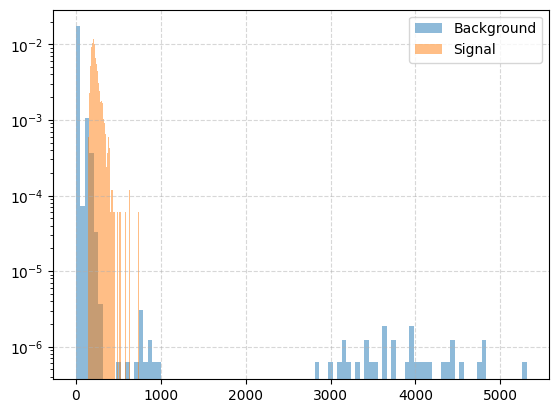

In [33]:
plt.hist(loss[y_val == BKG], bins=100, density=True, alpha=0.5, label="Background")
plt.hist(loss[y_val == SIGNAL], bins=100, density=True, alpha=0.5, label="Signal")
plt.grid(True, linestyle='--', alpha=0.5)
plt.yscale("log")
plt.legend()
plt.show()

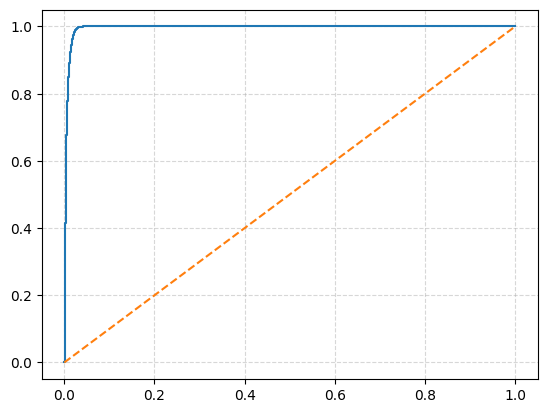

0.9946919469482103

In [34]:
fpr, tpr, _ = roc_curve(y_val, loss)#, sample_weight=W_val)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()
roc_auc_score(y_val, loss)